In [2]:
import torch
from cosyvoice.cli.cosyvoice import CosyVoice

# 1. 加载模型
print("Loading model...")
cosy = CosyVoice(r"D:\EduKillers\25Second\DeepLearning\Assignment2\models\CosyVoice-300M")
llm = cosy.model.llm.llm

print("\n" + "="*30)
print("   Model Architecture Info")
print("="*30)

# --- 方法 A: 尝试直接访问常见属性 ---
if hasattr(llm, "output_size"):
    print(f"Hidden Size (from output_size): {llm.output_size()}")
elif hasattr(llm, "d_model"):
    print(f"Hidden Size (from d_model): {llm.d_model}")

# --- 方法 B: 通过遍历子模块来硬核计数 ---
# 1. 获取 Hidden Size (找第一个 Linear 层)
for name, module in llm.named_modules():
    if isinstance(module, torch.nn.Linear):
        print(f"Hidden Size (inferred from first Linear): {module.in_features}")
        break

# 2. 获取 Layers 数量 (找重复出现的 Block)
# 常见的层命名包括 'encoders', 'layers', 'blocks'
num_layers = 0
first_layer = None
if hasattr(llm, "encoders"):
    num_layers = len(llm.encoders)
    first_layer = llm.encoders[0]
elif hasattr(llm, "layers"):
    num_layers = len(llm.layers)
    first_layer = llm.layers[0]
elif hasattr(llm, "blocks"):
    num_layers = len(llm.blocks)
    first_layer = llm.blocks[0]

print(f"Number of Layers: {num_layers}")

# 3. 获取 Attention Heads (深入到第一层里去找)
# 注意：这一步取决于具体的实现细节，可能会打印出 None
if first_layer is not None:
    # 尝试找 self_attn 模块
    for name, mod in first_layer.named_modules():
        if "attn" in name and hasattr(mod, "num_heads"): # 很多注意力实现会有 num_heads 属性
            print(f"Attention Heads: {mod.num_heads}")
            break
        elif "attn" in name and hasattr(mod, "n_head"):  # 或者叫 n_head
            print(f"Attention Heads: {mod.n_head}")
            break
        elif "attn" in name and hasattr(mod, "h"):       # 有些库叫 h
            print(f"Attention Heads: {mod.h}")
            break

print("="*30)

# 如果上面的自动检测失败，可以直接打印整个结构自己数（会很长）
# print(llm)

Loading model...


2025-12-10 13:58:58,394 INFO input frame rate=50
2025-12-10 13:59:00,124 DEBUG Starting new HTTPS connection (1): www.modelscope.cn:443


2025-12-10 13:59:00,538 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/revisions HTTP/1.1" 200 222
2025-12-10 13:59:00,747 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/repo/files?Revision=master&Recursive=True HTTP/1.1" 200 None
2025-12-10 13:59:00,927 DEBUG Starting new HTTPS connection (1): www.modelscope.cn:443


2025-12-10 13:59:01,397 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/revisions HTTP/1.1" 200 222
2025-12-10 13:59:01,520 DEBUG https://www.modelscope.cn:443 "GET /api/v1/models/pengzhendong/wetext/repo/files?Revision=master&Recursive=True HTTP/1.1" 200 None



   Model Architecture Info
Hidden Size (from output_size): 1024
Hidden Size (inferred from first Linear): 1024
Number of Layers: 14
Attention Heads: 16


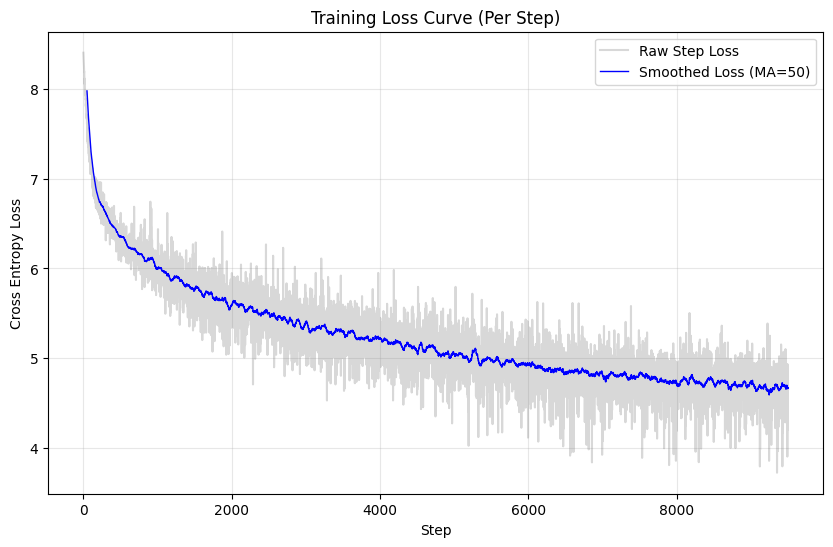

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np

# 读取日志
with open(r"D:\EduKillers\25Second\DeepLearning\Assignment2\training_log.json", "r") as f:
    data = json.load(f)

steps_loss = data["steps"]

# 为了让曲线平滑好看（因为 step loss 波动很大），我们可以做一个滑动平均
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# 原始数据太密集，画滑动平均线
smoothed_loss = moving_average(steps_loss, n=50) # n可以调整，越大越平滑

plt.figure(figsize=(10, 6))
plt.plot(steps_loss, alpha=0.3, label='Raw Step Loss', color='gray') # 原始噪点背景
plt.plot(range(49, 49 + len(smoothed_loss)), smoothed_loss, label='Smoothed Loss (MA=50)', color='blue', linewidth=1)
plt.title("Training Loss Curve (Per Step)")
plt.xlabel("Step")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("training_loss_curve.png")
plt.show()